In [1]:
# Make sure you are running under a virtual environment
! pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os 
import gdown

if not os.path.exists('data'):
    os.makedirs('data')
    gdown.download("https://drive.google.com/file/d/1pX6eLIK1kYzqSpbx-uTL6GuywHPhd1TE/view?usp=drive_link",
                   "data/tweets.zip", fuzzy=True)
    ! cd data && unzip tweets.zip

TWEETS_CSV = 'data/tweets.csv'

Downloading...
From: https://drive.google.com/uc?id=1pX6eLIK1kYzqSpbx-uTL6GuywHPhd1TE
To: /home/amit/runi-bigdata-2024/Final/runi-bigdata-2024/final/data/tweets.zip
100%|██████████| 2.96M/2.96M [00:00<00:00, 8.71MB/s]


Archive:  tweets.zip
  inflating: tweets.csv              


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

## Task 1

At first we attempted to use Twitter API, but the free access was too limited and therfore blocked us from fetching tweets using the API:

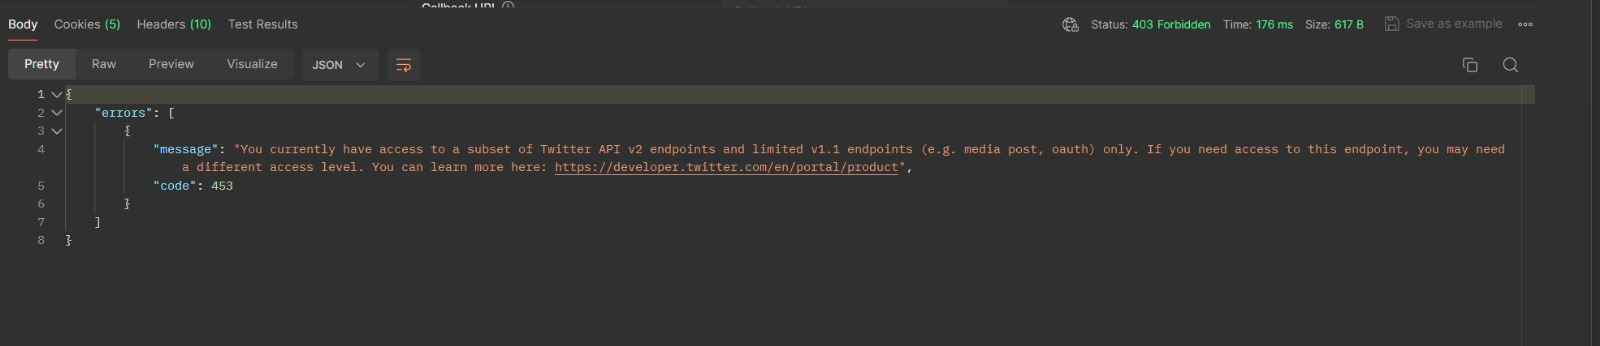

As an alternative, we opted to use the suggested Kaggle dataset.

The dataset source can be found here:
https://www.kaggle.com/datasets/mmmarchetti/tweets-dataset


In [4]:
tweets=pd.read_csv(TWEETS_CSV)
tweets.head()

,author,content,country,date_time,id,language,latitude,longitude,number_of_likes,number_of_shares
0,katyperry,Is history repeating itself...?#DONTNORMALIZEH...,NaN,12/01/2017 19:52,8.196330e+17,en,NaN,NaN,7900,3472
1,katyperry,@barackobama Thank you for your incredible gra...,NaN,11/01/2017 08:38,8.191010e+17,en,NaN,NaN,3689,1380
2,katyperry,Life goals. https://t.co/XIn1qKMKQl,NaN,11/01/2017 02:52,8.190140e+17,en,NaN,NaN,10341,2387
3,katyperry,Me right now 🙏🏻 https://t.co/gW55C1wrwd,NaN,11/01/2017 02:44,8.190120e+17,en,NaN,NaN,10774,2458
4,katyperry,SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...,NaN,10/01/2017 05:22,8.186890e+17,en,NaN,NaN,17620,4655


## Task 2 - Kubernetes Cluster Configuration

## Task 3 - Data Ingestion and Processing

In order to allow for insightful analysis in an efficient manner, we decided to create a pre-structured dataset that corresponds to the insights that we plan to offer.

The insights the engine will offer:

* Most popular hashtags by year
* Most popular author by year
* Correlation between hashtag and number of likes / shares
* Correlation between number of likes and number of shares
* Graph of mentions given author
* Emoji histogram
* Most used emoji given author

### Hashtags

- **Table Name**: `hashtag_stats`
- **Primary Key**:, 
  - **Partition Key**: `tag_name`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `tag_name` (text)
  - `number_of_likes` (int)
  - `number_of_shares` (int)
  - `country` (text)
  - `latitude` (float)
  - `longitude` (float)

### Author Popularity

- **Table Name**: `authors_stats`
- **Primary Key**:, 
  - **Partition Key**: `author_name`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `author_name` (text)
  - `number_of_likes` (int)
  - `number_of_shares` (int)
  - `country` (text)
  - `latitude` (float)
  - `longitude` (float)

### User Mentions

- **Table Name**: `user_mention`
- **Primary Key**:, 
  - **Partition Key**: `user_name, mention_name`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `user_name` (text)
  - `mention_name` (text)

### Emoji Stats

- **Table Name**: `emoji_stats`
- **Primary Key**:, 
  - **Partition Key**: `emoji, author`
  - **Clustering Key**: `date_time`
- **Columns**:
  - `date_time` (timestamp)
  - `emoji` (text)
  - `author` (text)
  - `number_of_likes` (int)
  - `number_of_shares` (int)
  - `country` (text)
  - `latitude` (float)
  - `longitude` (float)

In [5]:
# Kill any running previous instance
! docker kill my_cassandra || echo true

# Setting up cassandra instance using docker with local persistent storage under the persistent_data folder.
# The cassandra.yaml file is also mounted to the container to allow for configuration changes.
! docker run --rm -d --name my_cassandra -p 9042:9042 -v `pwd`/cassandra.yaml:/etc/cassandra/cassandra.yaml -v `pwd`/persistent_data:/var/lib/cassandra cassandra 

Error response from daemon: Cannot kill container: my_cassandra: No such container: my_cassandra
true
f8f13ba667ab7f0be2e28a6668cdc8289619bd3e391933f217fabcae2a378637


In [7]:
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra.query import SimpleStatement

# Setup Cassandra Connection
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()

In [8]:
# Create Keyspace and Tables

if 'BatchStatement' in locals():
    session.execute("DROP KEYSPACE IF EXISTS twitter_insights")

if 'Cluster' in locals():
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS twitter_insights WITH replication = {
            'class': 'SimpleStrategy', 'replication_factor': '3'
        }
    """)

    session.set_keyspace('twitter_insights')

    session.execute("""
        CREATE TABLE IF NOT EXISTS hashtag_stats (
            date_time timestamp,
            year int,
            tag_name text,
            number_of_likes int,
            number_of_shares int,
            country text,
            latitude float,
            longitude float,
            PRIMARY KEY (tag_name, year, date_time)
        );
    """)

    session.execute("""
        CREATE TABLE IF NOT EXISTS author_stats (
            date_time timestamp,
            author_name text,
            number_of_likes int,
            number_of_shares int,
            country text,
            latitude float,
            longitude float,
            PRIMARY KEY (author_name, date_time)
        );
    """)

    session.execute("""
        CREATE TABLE IF NOT EXISTS emoji_stats (
            date_time timestamp,
            emoji text,
            author text,
            number_of_likes int,
            number_of_shares int,
            country text,
            latitude float,
            longitude float,
            PRIMARY KEY ((emoji, author), date_time)
        );
    """)


In [9]:
# Setting the batch size so that we can control the number of rows inserted per batch
batch_size = 1024*25 # 25KB

In [10]:
import re

# Create individual insert statements
insert_authors_popularity = session.prepare(
    f"INSERT INTO author_stats (date_time, author_name, number_of_likes, number_of_shares) "
    f"VALUES (?, ?, ?, ?)"
)
insert_hashtag_stats = session.prepare(
    f"INSERT INTO hashtag_stats (date_time, year, tag_name, number_of_likes, number_of_shares) "
    f"VALUES (?, ?, ?, ?, ?)"
)
insert_emoji_stats = session.prepare(
    f"INSERT INTO emoji_stats (date_time, emoji, author, number_of_likes, number_of_shares) "
    f"VALUES (?, ?, ?, ?, ?)"
)

def extract_hashtags(tweet):
    # Define the regex pattern for hashtags
    hashtag_pattern = r'#\w+'

    # Find all hashtags in the tweet
    hashtags = re.findall(hashtag_pattern, tweet)

    return hashtags

def extract_emojis(tweet):
    # Define the regex pattern for emojis
    emoji_pattern = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF]'

    # Find all emojis in the tweet
    emojis = re.findall(emoji_pattern, tweet, flags=re.UNICODE)

    return emojis

# Ingestion of tweets
batch = BatchStatement()
for index, row in tweets.iterrows():
    # Extract data from the CSV row
    date_time = pd.to_datetime(row['date_time'])
    author_name = row['author']
    number_of_likes = int(row['number_of_likes'])
    number_of_shares = int(row['number_of_shares'])
    content = row['content']
    # Note: Current dataset includes empty geo fields, ignoring them for this calculation.
    # country = row['country']
    # latitude = float(row['latitude'])
    # longitude = float(row['longitude'])

    # Insert data into author_stats table
    batch.add(
        insert_authors_popularity,
        (date_time, author_name, number_of_likes, number_of_shares)
    )

    # Insert data into hashtag_stats table
    hashtags = extract_hashtags(content)
    for hashtag in hashtags:
        batch.add(
            insert_hashtag_stats,
            (date_time, date_time.year, hashtag, number_of_likes, number_of_shares)
        )

    # Insert data into emoji_stats table
    emojis = extract_emojis(content)
    for emoji in emojis:
        batch.add(
            insert_emoji_stats,
            (date_time, emoji, author_name, number_of_likes, number_of_shares)
        )

    if index % batch_size == 0:
        session.execute(batch)
        batch.clear()

session.execute(batch)


/tmp/ipykernel_2299/2488258634.py:39: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date_time = pd.to_datetime(row['date_time'])


# Task 4 - Data Analysis and Insight Extraction

Execute these two commands, in order to start a cqlsh session within our cassandra container, which allows us to run CQL commands directly against your Cassandra database.

Starting a `cqlsh` session on the instance:
`docker exec -it my_cassandra cqlsh`

Applying the keyspace:
`use twitter_insights`

-- Query1: Most Popular Hashtags by Year
-- To find the most popular hashtags by year, we can aggregate the number of likes or shares for each hashtag, grouped by year, and sort them in descending order by likes.

```SQL
SELECT tag_name, year, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM hashtag_stats
GROUP BY year, tag_name
ORDER BY year ASC, total_likes DESC
LIMIT 10;
```

-- Query2: Most Popular Author by Year
-- Similar to hashtags, we aggregate the number of likes and shares for each author, filtering by year, to find the most popular author.

```SQL
SELECT author_name, year, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM author_stats
WHERE year = 2023
GROUP BY author_name
ORDER BY total_likes DESC
LIMIT 1;
```

-- Query3: Correlation between Hashtag and Likes/Shares
-- This query calculates the correlation coefficient between the number of likes and shares for a specific hashtag.

```SQL
SELECT tag_name, CORR(number_of_likes, number_of_shares) AS correlation
FROM hashtag_stats
WHERE tag_name = 'your_hashtag'
ALLOW FILTERING;
```

-- Query4: Correlation between Likes and Shares Globally
-- To understand the global relationship between likes and shares across all hashtags, we calculate the correlation coefficient globally.

```SQL
SELECT CORR(number_of_likes, number_of_shares) AS global_correlation
FROM hashtag_stats;
```

-- Query5: Graph of Mentions Given Author
-- Assuming a user_mention table, this query retrieves all mentions for a given author

```SQL
SELECT mention_name
FROM user_mention
WHERE user_name = 'your_author';
```

-- Query6: Emoji Histogram
-- To understand emoji usage, this query counts the occurrences of each emoji, sorting them to create a histogram of most used emojis.

```SQL
SELECT emoji, COUNT(*) AS frequency
FROM emoji_stats
GROUP BY emoji
ORDER BY frequency DESC;
```

-- Query7: Most Used Emoji Given Author
-- For a specific author, this query finds the most used emoji by aggregating likes and shares, providing insights into the author's emoji preferences.

```SQL
SELECT emoji, SUM(number_of_likes) + SUM(number_of_shares) AS total_interactions
FROM emoji_stats
WHERE author = 'your_author'
GROUP BY emoji
ORDER BY total_interactions DESC
LIMIT 1;
```

-- Query8: Daily Active Users
-- To find the number of unique authors per day, which can help understand daily user engagement and activity levels.

```SQL
SELECT date_time, COUNT(DISTINCT author_name) AS daily_active_users
FROM author_stats
GROUP BY date_time
ORDER BY date_time ASC;
```

-- Query9: Hashtag Trend Over Time
-- To analyze the popularity of a specific hashtag over time, this query tracks the sum of likes and shares for a hashtag across different months or years, providing insight into its trending status.

```SQL
SELECT year, month, tag_name, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM hashtag_stats
WHERE tag_name = 'specific_hashtag'
GROUP BY year, month, tag_name
ORDER BY year ASC, month ASC;
```

-- Query10: Top Countries by User Engagement
-- To identify which countries have the highest user engagement, by aggregating likes and shares for tweets originating from different countries.

```SQL
SELECT country, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM author_stats
GROUP BY country
ORDER BY total_likes DESC, total_shares DESC
LIMIT 10;
```

In [15]:
# for ease of use we will define all the queries
queries = {
    "Most Popular Hashtags by Year": """
    SELECT tag_name, year, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
    FROM hashtag_stats
    GROUP BY year, tag_name
    ORDER BY year ASC, total_likes DESC
    LIMIT 10;
    """,
    "Most Popular Author by Year": """
    SELECT author_name, year, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
    FROM author_stats
    WHERE year = 2023
    GROUP BY author_name
    ORDER BY total_likes DESC
    LIMIT 1;
    """,
    "Correlation between Hashtag and Likes/Shares": """
    SELECT tag_name, CORR(number_of_likes, number_of_shares) AS correlation
    FROM hashtag_stats
    WHERE tag_name = '#TheUncommonThread'
    ALLOW FILTERING;
    """,
    "Correlation between Likes and Shares Globally": """
    SELECT CORR(number_of_likes, number_of_shares) AS global_correlation
    FROM hashtag_stats;
    """,
    "Graph of Mentions Given Author": """
    SELECT mention_name
    FROM user_mention
    WHERE user_name = 'katyperry';
    """,
    "Emoji Histogram": """
    SELECT emoji, COUNT(*) AS frequency
    FROM emoji_stats
    GROUP BY emoji
    ORDER BY frequency DESC;
    """,
    "Most Used Emoji Given Author": """
    SELECT emoji, SUM(number_of_likes) + SUM(number_of_shares) AS total_interactions
    FROM emoji_stats
    WHERE author = 'katyperry'
    GROUP BY emoji
    ORDER BY total_interactions DESC
    LIMIT 1;
    """,
    "Daily Active Users": """
    SELECT date_time, COUNT(DISTINCT author_name) AS daily_active_users
    FROM author_stats
    GROUP BY date_time
    ORDER BY date_time ASC;
    """,
    "Hashtag Trend Over Time": """
    SELECT year, month, tag_name, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
    FROM hashtag_stats
    WHERE tag_name = '#TheUncommonThread'
    GROUP BY year, month, tag_name
    ORDER BY year ASC, month ASC;
    """,
    "Top Countries by User Engagement": """
    SELECT country, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
    FROM author_stats
    GROUP BY country
    ORDER BY total_likes DESC, total_shares DESC
    LIMIT 10;
    """
}

In [16]:
# Execute each query and store results in a DataFrame
dataframes = {}
for query_name, query in queries.items():
    rows = session.execute(query)
    dataframes[query_name] = pd.DataFrame(list(rows))

InvalidRequest: Error from server: code=2200 [Invalid query] message="Undefined column name total_likes in table twitter_insights.hashtag_stats"

## Question 5

In [11]:
rows = session.execute("""
SELECT tag_name, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM hashtag_stats
GROUP BY tag_name
LIMIT 10
ALLOW FILTERING;
""")

pd.DataFrame(list(rows))

,tag_name,total_likes,total_shares
0,#TheUncommonThread,24943,11705
1,#WorkBxxchVideoTomorrow,4222,6561
2,#EnterSandman,1369,308
3,#londoniloveyou,14859,16777
4,#VMAafterparty,961,1102
5,#WHPresolutions,5256,1094
6,#TS1989,1636063,749016
7,#AUS,3170,1287
8,#ThereISaidIt,13426,5040
9,#1989touratlanta,41098,16410


In [12]:
rows = session.execute("""
SELECT tag_name, SUM(number_of_likes) AS total_likes, SUM(number_of_shares) AS total_shares
FROM hashtag_stats
GROUP BY tag_name
ORDER BY total_likes DESC
LIMIT 10
ALLOW FILTERING;
""")

df = pd.DataFrame(list(rows))

# Ignore noise and irrelevant measurments 
df_filtered = df[df['average_value'] != -1]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['measurement_date'], df_filtered['average_value'], marker='o', linestyle='None', color='b')
plt.title('Average Value of Pollutant Over Time in 2019 (Without -1 Values)')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

InvalidRequest: Error from server: code=2200 [Invalid query] message="Undefined column name total_likes in table twitter_insights.hashtag_stats"